In [13]:
import os, re
import numpy as np
import joblib
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [14]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3060


In [15]:
filenames = os.listdir('datasets')
num_resolutions = []
timebuckets = []
pattern_test = re.compile(r'test_dataset_res_(\d+)_bucket_(\d+)\.pt')
for filename in filenames:
    match_test = pattern_test.match(filename)
    if match_test:
        X, Y = map(int, match_test.groups())
        if (X - 6) not in num_resolutions:
            num_resolutions.append(X - 6)
        if Y not in timebuckets:
            timebuckets.append(Y)

num_resolutions = len(num_resolutions)
timebuckets = sorted(timebuckets)
test_dl = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
for i in range(num_resolutions):
    for j in range(len(timebuckets)):
        test_dl[i][j] = DataLoader(
            torch.load(f'datasets/test_dataset_res_{i + 6}_bucket_{timebuckets[j]}.pt', weights_only = False),
            batch_size = 128,
            shuffle = False
        )

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return self.relu(x)

In [17]:
predicted_demand = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
actual_demand = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
for i in range(num_resolutions):
    for j in range(len(timebuckets)):
        model = NeuralNetwork(23).to(device)
        model.load_state_dict(torch.load(f'trained_models/nn_model_res_{i + 6}_bucket_{timebuckets[j]}.pth', weights_only = False))
        loss_fn = nn.MSELoss()
        model.eval()
        test_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for X_batch, y_batch in test_dl[i][j]:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y_batch.cpu().numpy())
                loss = loss_fn(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_loss /= len(test_dl[i][j].dataset)
        print(f'Test Loss for Resolution {i + 6} and Timebucket {timebuckets[j]}: {test_loss:.7f}')
        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        target_scaler = joblib.load(f'scalers/target_scaler_res_{i + 6}_bucket_{timebuckets[j]}.pkl')
        predicted_demand[i][j] = target_scaler.inverse_transform(predictions)
        actual_demand[i][j] = target_scaler.inverse_transform(actuals)

Test Loss for Resolution 6 and Timebucket 1: 0.0005921
Test Loss for Resolution 6 and Timebucket 2: 0.0006084
Test Loss for Resolution 6 and Timebucket 4: 0.0007538
Test Loss for Resolution 6 and Timebucket 6: 0.0014463
Test Loss for Resolution 6 and Timebucket 24: 0.0018590
Test Loss for Resolution 7 and Timebucket 1: 0.0004807
Test Loss for Resolution 7 and Timebucket 2: 0.0005281
Test Loss for Resolution 7 and Timebucket 4: 0.0005545
Test Loss for Resolution 7 and Timebucket 6: 0.0005366
Test Loss for Resolution 7 and Timebucket 24: 0.0008920
Test Loss for Resolution 8 and Timebucket 1: 0.0005345
Test Loss for Resolution 8 and Timebucket 2: 0.0005003
Test Loss for Resolution 8 and Timebucket 4: 0.0005205
Test Loss for Resolution 8 and Timebucket 6: 0.0005089
Test Loss for Resolution 8 and Timebucket 24: 0.0012159


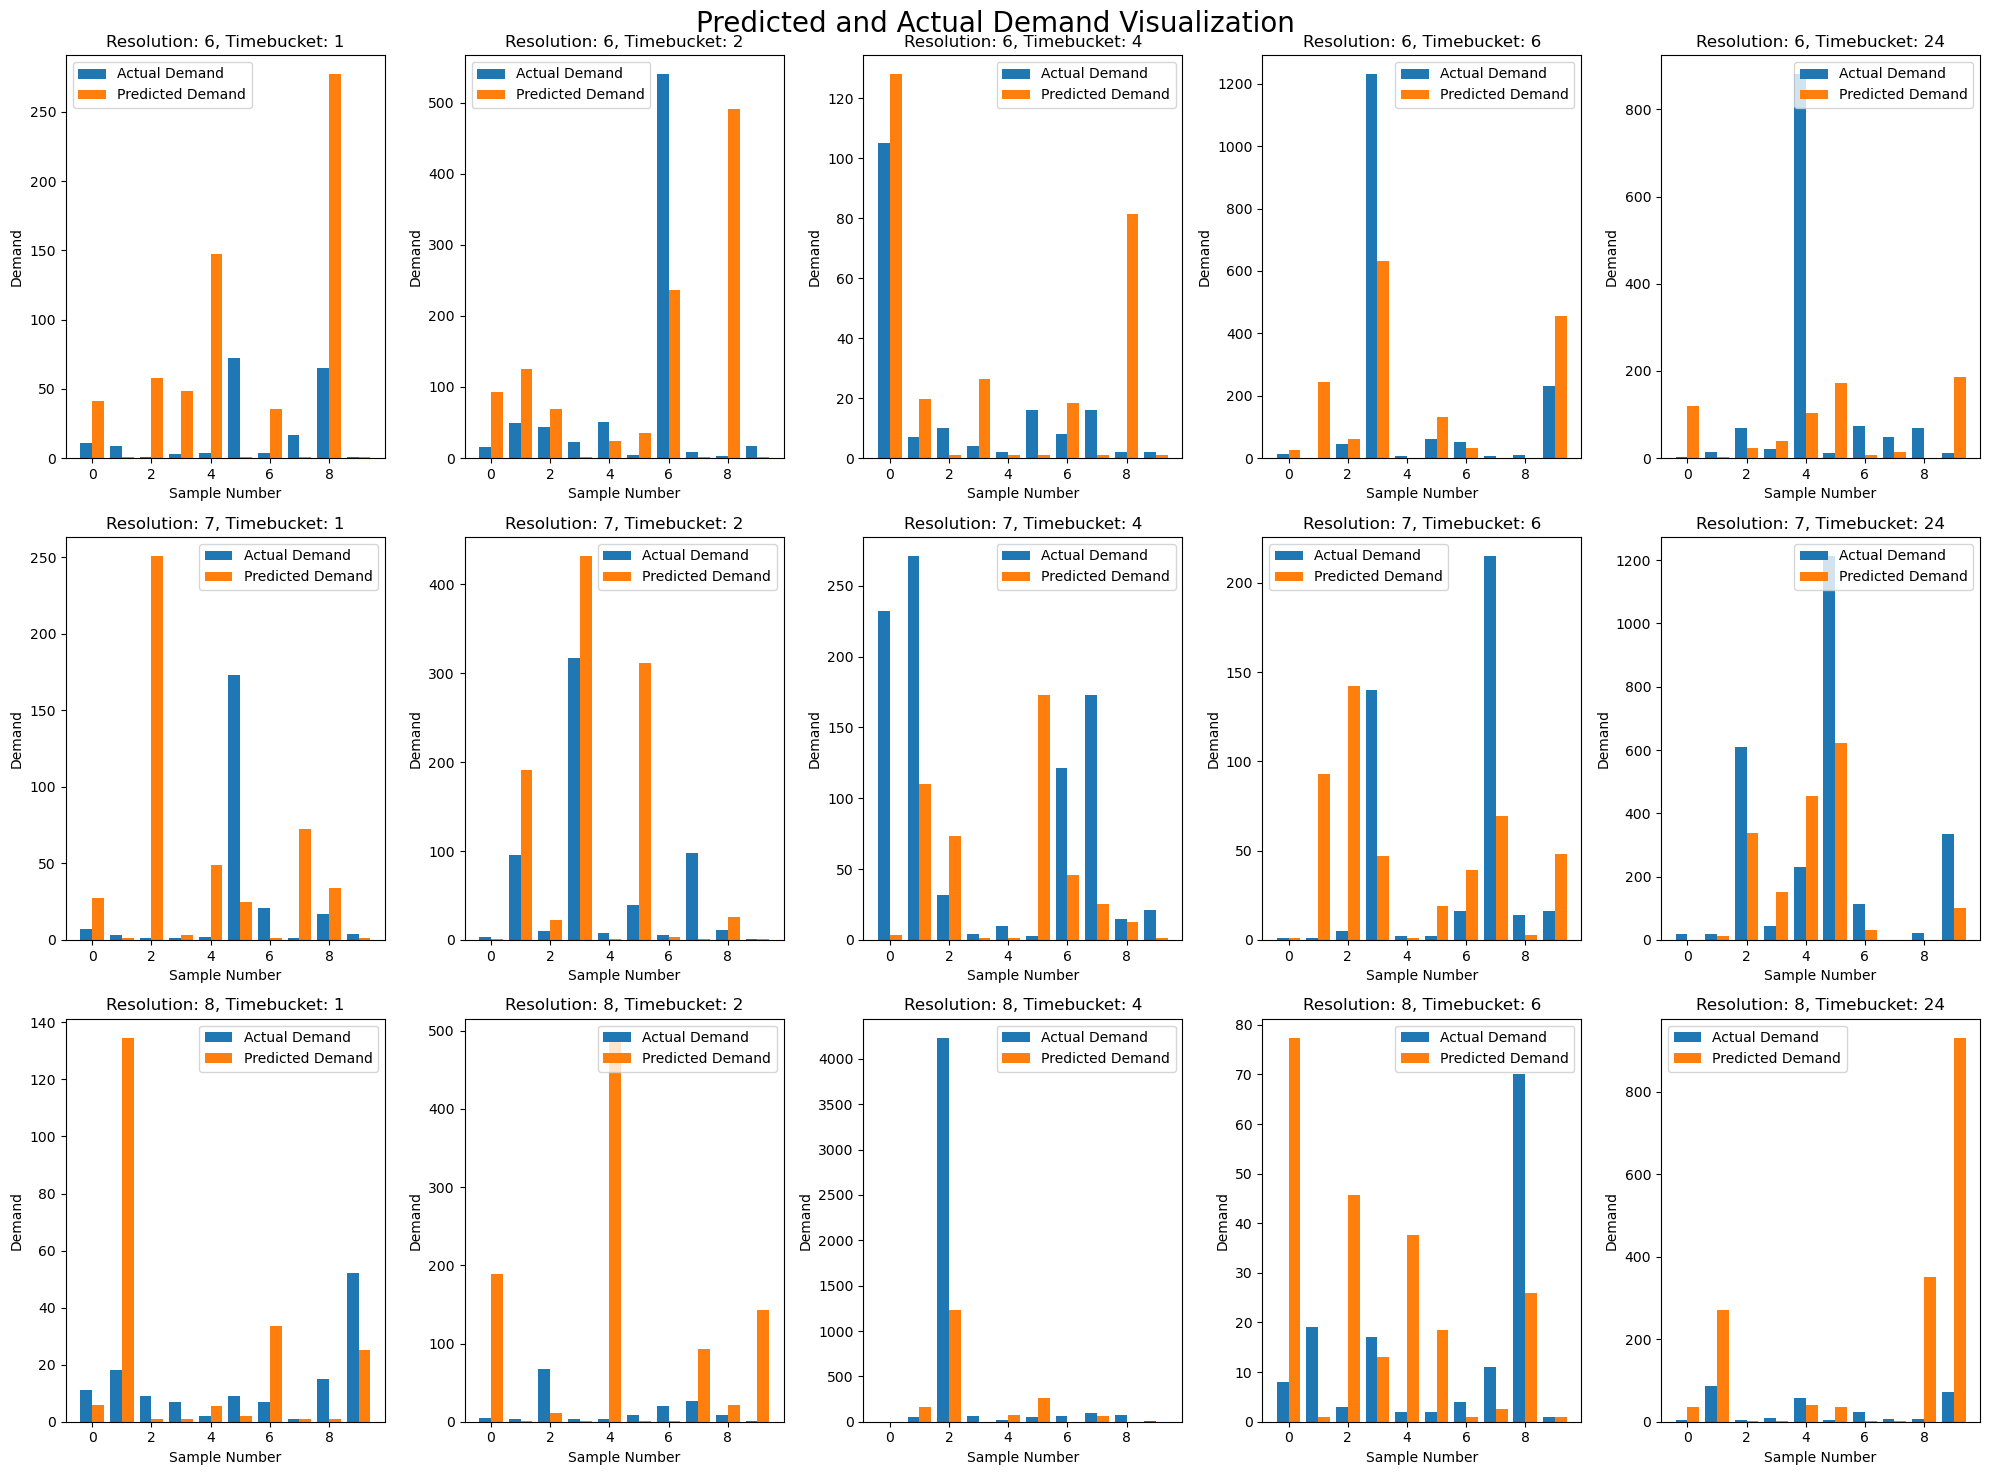

In [18]:
fig, axs = plt.subplots(num_resolutions, len(timebuckets), figsize=(20, 15))
fig.suptitle('Predicted and Actual Demand Visualization', size = 20)
for row in range(num_resolutions):
    for col in range(len(timebuckets)):
        ax = axs[row, col]
        random_indices = np.random.choice(len(predicted_demand[i][j]), size=10, replace=False)
        predictions_sample = predicted_demand[i][j][random_indices]
        actuals_sample = actual_demand[i][j][random_indices]
        indices = np.arange(len(predictions_sample))
        ax.bar(indices - 0.2, actuals_sample.flatten(), width=0.4, label='Actual Demand')
        ax.bar(indices + 0.2, predictions_sample.flatten(), width=0.4, label='Predicted Demand')
        ax.set_title(f'Resolution: {row + 6}, Timebucket: {timebuckets[col]}')
        ax.set_xlabel('Sample Number')
        ax.set_ylabel('Demand')
        ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('images/test_results.png', dpi = 600)
plt.show()